# Design of comparative analysis - OOR state detection simulation

In this notebook we benchmark the ability to recover out-of-reference (OOR) cell states using 4 alternative designs for comparative analysis

- Atlas reference (AR design): mapping perturbed cells to an all-encompassing atlas dataset
- Control reference with query mapping (CR scArches design): mapping perturbed cells to a matched control dataset
- Control reference with joint embedding (CR scVI design): mapping perturbed cells to a matched control dataset
- Atlas and Control reference (ACR design): mapping perturbed and control cells to an all-encompassing atlas dataset

Here we use differential abundance analysis with Milo to assess the accuracy of query-specific cell detection. For alternative comparisons see: 

- `src/2_simulation_design/oor_design_main/DA_methods.ipynb` - alternative DA methods
- `src/2_simulation_design/mappingQC_comparison/mappingQC_comparison.ipynb` - comparison with query mapping quality metrics
- `src/2_simulation_design/DE_comparison/DE_comparison.ipynb` - comparison with differential expression analysis based OOR derection 


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import oor_benchmark
import oor_benchmark.metrics.utils

sns.set_context('talk')
from matplotlib.pyplot import rc_context

In [5]:
figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/pbmc_design_comparison_v2/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [6]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)


In [7]:
%load_ext rpy2.ipython

In [8]:
%%R -i figdir
library(tidyverse)
library(patchwork)
library(ggrastr)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [9]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');
    
def make_ct_label(label):
    return(' '.join(label.split('_')))

In [10]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR scArches':pal[7], 'AR':pal[9], 'CR scVI':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [11]:
%%R -i design_palette_df
design_palette <- setNames(design_palette_df$color, rownames(design_palette_df))

scale_color_design <- function(){
    scale_color_manual(values=design_palette, name='design')
}

scale_fill_design <- function(){
    scale_color_manual(values=design_palette, name='design')
}

In [12]:

short_pop_names = {
    "DC":'conventional_dendritic_cell', 
    "naive B":'naive_B_cell',
    "memory B":'memory_B_cell',
    "CM CD4+T":'central_memory_CD4_positive_alpha_beta_T_cell', 
    'plasmablast':'plasmablast',
    'platelet':'platelet', 
 "pDC":'plasmacytoid_dendritic_cell',
     "neutrophil":'neutrophil',
#     "cDC":'conventional_dendritic_cell',
 'naive CD4+T':'naive_thymus_derived_CD4_positive_alpha_beta_T_cell',
"classical monocyte":'classical_monocyte', 
    'CD14+ monocyte':'CD14_positive_monocyte',
 'erythrocyte':'erythrocyte',
       "naive CD8+T":'naive_thymus_derived_CD8_positive_alpha_beta_T_cell',
       "NK":'natural_killer_cell',
       "EM CD8+T":'effector_memory_CD8_positive_alpha_beta_T_cell',
       'MAIT':'mucosal_invariant_T_cell', 
 'CD14lo CD16hi monocyte':'CD14_low_CD16_positive_monocyte',
    "HPP":'hematopoietic_precursor_cell'
}

short_pop_names={v:k for k,v in short_pop_names.items()}

## Experiment set-up

See `submit_oor_design_v2.sh` for parameters

## Parse results 

In [1]:
outdir = '/lustre/scratch126/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
population_obs = 'cell_type'
batch_obs = 'dataset_id'

In [17]:
## Get OOR state population size
oor_state_size = {}
for d in [d for d in os.listdir(outdir) if d.endswith('_seed2022') and d.startswith('qPBMC_500cells_demo_perturb')]:
        if 'neutrophil' not in d:
            acr_adata = sc.read_h5ad(outdir + d +'/acr_design.h5ad', backed=True)
            ct = acr_adata.obs[acr_adata.obs['OOR_state']==1]['cell_type'].unique()[0]
            oor_state_size[ct] = acr_adata.obs['OOR_state'].sum()

oor_state_frac = {k:v/(500*(14+16)) for k,v in oor_state_size.items()}
oor_state_frac

oor_state_size

{'memory_B_cell': 398,
 'conventional_dendritic_cell': 108,
 'naive_B_cell': 601,
 'central_memory_CD4_positive_alpha_beta_T_cell': 1811,
 'plasmablast': 15,
 'platelet': 123,
 'plasmacytoid_dendritic_cell': 43,
 'naive_thymus_derived_CD4_positive_alpha_beta_T_cell': 779,
 'classical_monocyte': 391,
 'erythrocyte': 10,
 'naive_thymus_derived_CD8_positive_alpha_beta_T_cell': 396,
 'natural_killer_cell': 1067,
 'effector_memory_CD8_positive_alpha_beta_T_cell': 1436,
 'mucosal_invariant_T_cell': 203,
 'CD14_low_CD16_positive_monocyte': 124}

In [13]:
nhoods_res_df_all = pd.DataFrame()
tpr_res_df_all = pd.DataFrame()
for d in [d for d in os.listdir(outdir) if d.endswith('_seed2022') and d.startswith('qPBMC_500cells_demo_perturb')]:
    diff_method = 'milo'
    for embedding_method in ['scVI', 'scArches']:
        print(f'Reading {d}')
        nhoods_res_df = pd.read_csv(outdir + d + f'/nhoods_obs.{embedding_method}_{diff_method}.csv', index_col = 0)
        nhoods_res_df['emb_method'] = embedding_method
        nhoods_res_df_all = pd.concat([nhoods_res_df_all, nhoods_res_df])
        tpr_res_df = pd.read_csv(outdir + d + f'/TPR_res.{embedding_method}_{diff_method}.csv', index_col = 0)
        tpr_res_df['emb_method'] = embedding_method
        tpr_res_df_all = pd.concat([tpr_res_df_all, tpr_res_df])

Reading qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeerythrocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeerythrocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeplasmablast_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeplasmablast_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typemucosal_invariant_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typemucosal_invariant_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_pe

In [14]:
nhoods_res_df_all = nhoods_res_df_all[nhoods_res_df_all.OOR_state_name != 'neutrophil']
tpr_res_df_all = tpr_res_df_all[tpr_res_df_all.OOR_state_name != 'neutrophil']

nhoods_res_df_all['perturb_pop_pl'] = [short_pop_names[x] for x in nhoods_res_df_all['OOR_state_name']]
tpr_res_df_all['perturb_pop_pl'] = [short_pop_names[x] for x in tpr_res_df_all['OOR_state_name']]

## Keep 4 designs
nhoods_res_df_all['design'] = np.where(nhoods_res_df_all['design'] == 'CR', nhoods_res_df_all['design'] + ' ' + nhoods_res_df_all['emb_method'], nhoods_res_df_all['design'])
tpr_res_df_all['design'] = np.where(tpr_res_df_all['design'] == 'CR', tpr_res_df_all['design'] + ' ' + tpr_res_df_all['emb_method'], tpr_res_df_all['design'])

nhoods_res_df_all = nhoods_res_df_all[nhoods_res_df_all['design'].isin(["ACR", 'AR', 'CR scVI', 'CR scArches'])].copy()
nhoods_res_df_all = nhoods_res_df_all[~((nhoods_res_df_all['design'] == 'ACR') & (nhoods_res_df_all['emb_method'] == 'scVI'))]
tpr_res_df_all = tpr_res_df_all[tpr_res_df_all['design'].isin(["ACR", 'AR', 'CR scVI', 'CR scArches'])].copy()
tpr_res_df_all = tpr_res_df_all[~((tpr_res_df_all['design'] == 'ACR') & (tpr_res_df_all['emb_method'] == 'scVI'))]

In [15]:
nhoods_res_df_all.to_csv('../../../metadata/outputs/OOR_simulations_remove.nhood_results_all.csv')
tpr_res_df_all.to_csv('../../../metadata/outputs/OOR_simulations_remove.TPRFPRFDR_results_all.csv')

## Plot OOR fraction vs logFC

In [28]:
%%R -i nhoods_res_df_all
head(nhoods_res_df_all)

                                             index_cell kth_distance
1 10_1038_s41591_021_01329_2-CTTAGGAGTTAAAGTG-MH8919178     1.633824
2 10_1038_s41591_021_01329_2-GTCTTCGTCCTGCCAT-MH8919178     1.597826
3 10_1038_s41591_021_01329_2-CAACCAATCTATCGCC-MH8919178     1.463025
4 10_1038_s41591_021_01329_2-CTCAGAAAGGATGCGT-MH8919178     1.621413
5 10_1038_s41591_021_01329_2-CACTCCAAGGATGGTC-MH8919178     1.526698
6 10_1038_s41591_021_01329_2-TGAGAGGAGACAGACC-MH8919178     1.568583
                                     nhood_annotation nhood_annotation_frac
1       central_memory_CD4_positive_alpha_beta_T_cell             0.8269231
2       central_memory_CD4_positive_alpha_beta_T_cell             0.9393939
3                                  classical_monocyte             0.9955157
4                                 natural_killer_cell             0.9238095
5                                  classical_monocyte             0.9858156
6 naive_thymus_derived_CD8_positive_alpha_beta_T_cell        

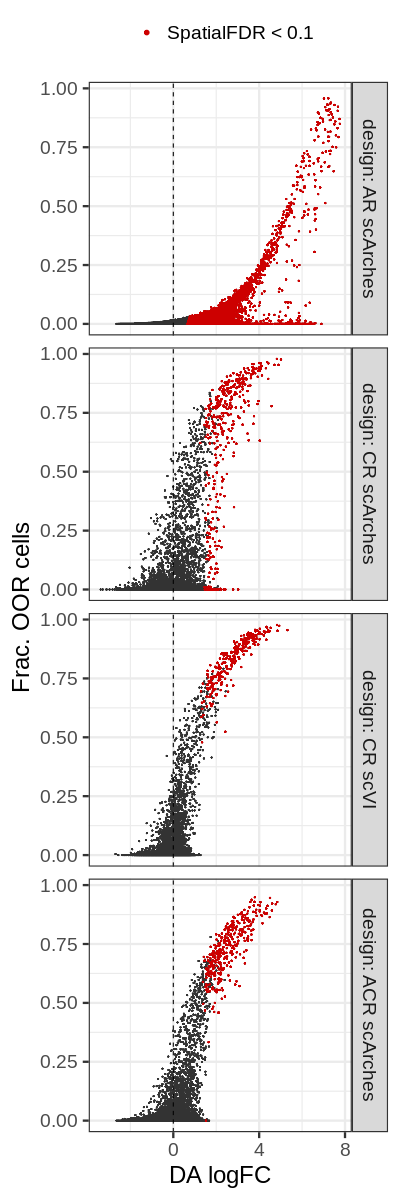

In [58]:
%%R -h 1200 -w 400 -i figdir
nhoods_res_df_all %>%
    mutate(design=factor(design, levels=c('AR scArches', 'CR scArches', 'CR scVI','ACR scArches'))) %>%
    ggplot(aes(OOR_score, frac_OOR_cells)) +
    rasterise(geom_point(size=0.3, color='grey20'), dpi=300) +
    rasterise(geom_point(data=. %>% filter(OOR_signif == 1), aes(color='SpatialFDR < 0.1'),
               size=0.4), dpi=300) +
    facet_grid(design~., labeller='label_both') +
    guides(color=guide_legend(title='', override.aes = list(size=2))) +
    theme_bw(base_size=24) +
    scale_color_manual(values = c(`SpatialFDR < 0.1` = 'red3')) +
    geom_vline(xintercept=0, linetype=2) +
    xlab('DA logFC') + ylab('Frac. OOR cells') +
    theme(legend.position='top') +
    ggsave(paste0(figdir, 'fracVSlogFC_all_ggplot.png'), width=6, height=12) +
    ggsave(paste0(figdir, 'fracVSlogFC_all_ggplot.pdf'), width=6, height=12)

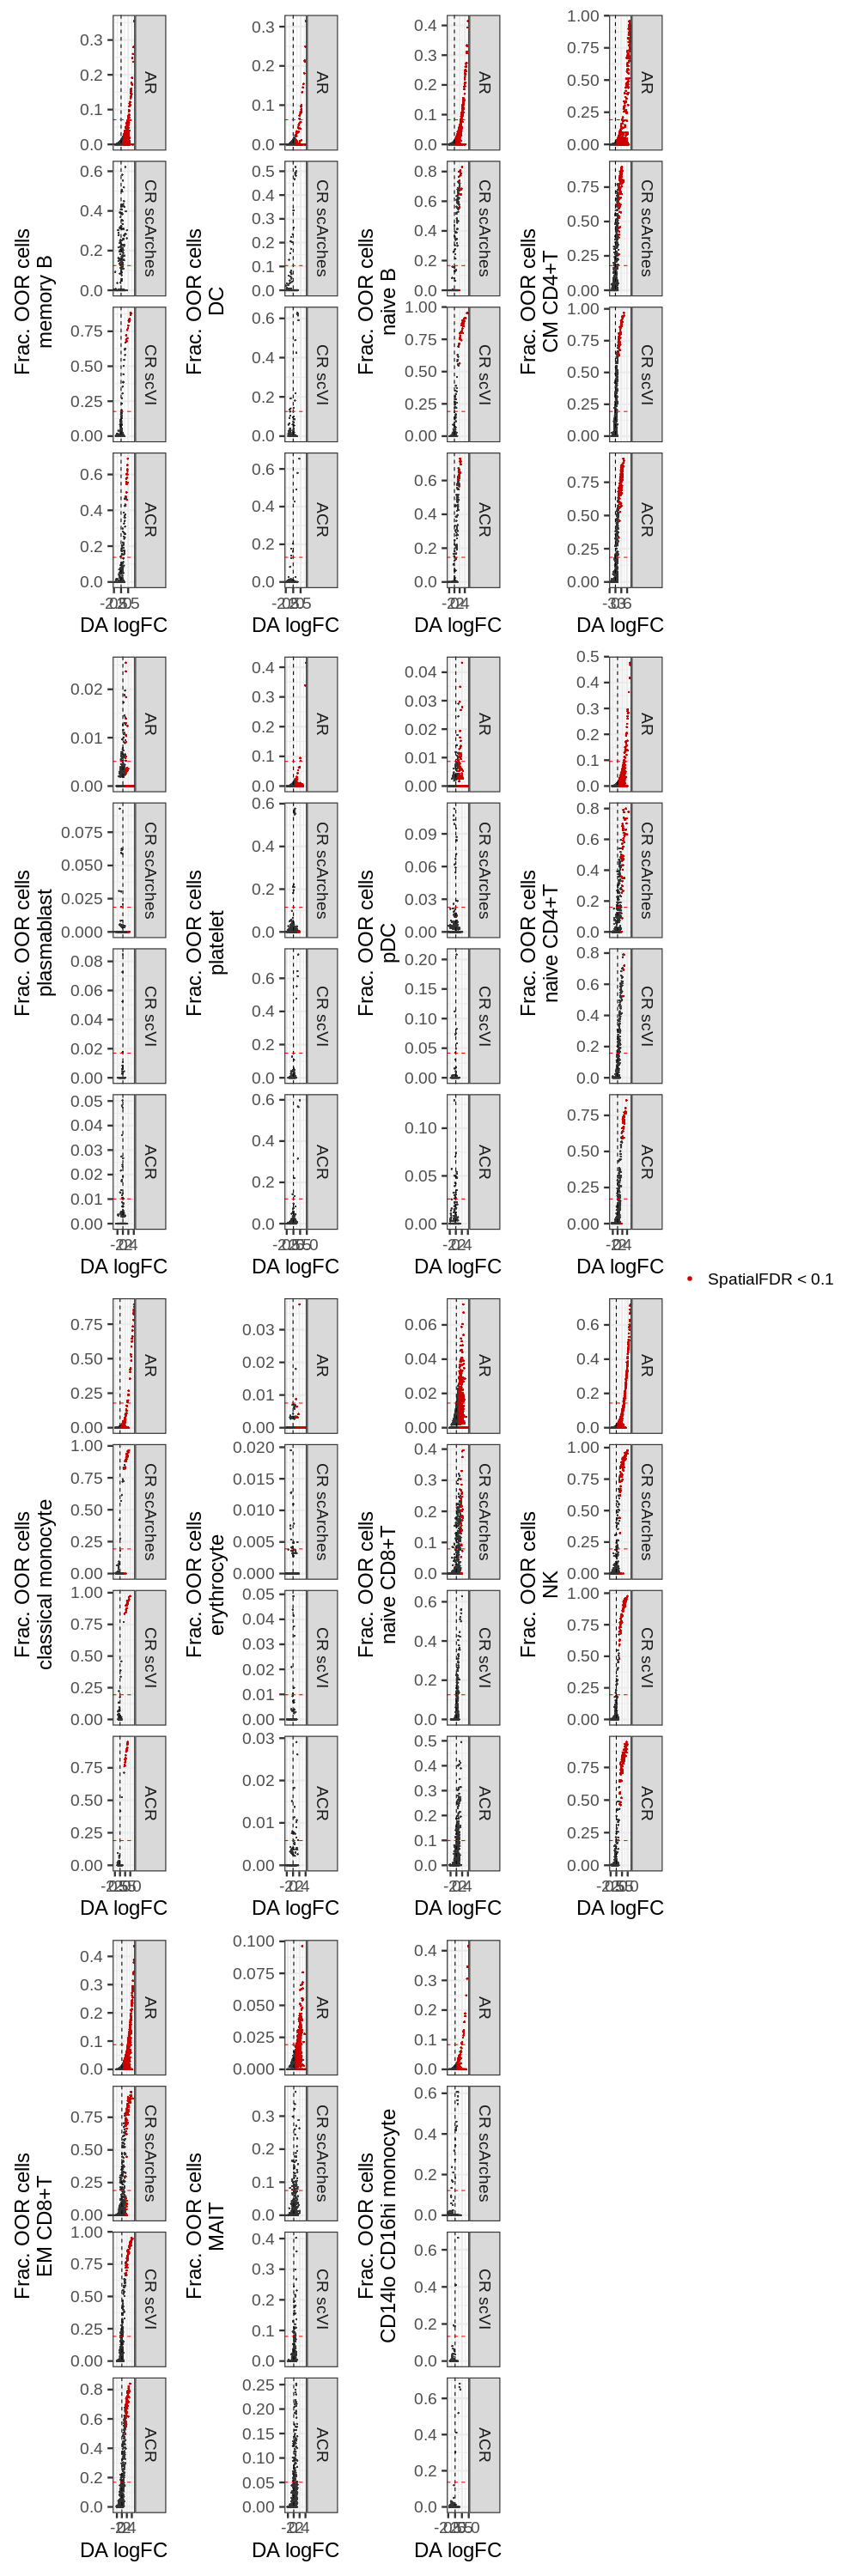

In [50]:
%%R -w 1000 -h 3000
pl_ls <- lapply(unique(nhoods_res_df_all$perturb_pop_pl), function(p){
    nhoods_res_df_all %>%
    mutate(design=factor(design, levels=c('AR', 'CR scArches', 'CR scVI','ACR'))) %>%
    group_by(OOR_state_name, design) %>%
    mutate(frac_thresh= max(frac_OOR_cells/100)*20) %>%
    ungroup() %>%
    filter(perturb_pop_pl %in% c(p)) %>%
    ggplot(aes(OOR_score, frac_OOR_cells)) +
    rasterise(geom_point(size=0.3, color='grey20'), dpi=300) +
    rasterise(geom_point(data=. %>% filter(OOR_signif == 1), aes(color='SpatialFDR < 0.1'),
               size=0.4), dpi=300) +
    facet_grid(design~., scales='free_y') +
    guides(color=guide_legend(title='', override.aes = list(size=2))) +
    theme_bw(base_size=24) +
    scale_color_manual(values = c(`SpatialFDR < 0.1` = 'red3')) +
    geom_vline(xintercept=0, linetype=2) +
    geom_hline(aes(yintercept=frac_thresh), linetype=2, color='red') +
    xlab('DA logFC') + ylab(paste0('Frac. OOR cells\n', p)) +
    theme(legend.position='top') 
    })

(wrap_plots(pl_ls, ncol=4, guides='collect') & {theme(legend.position='right') }) +
    ggsave(paste0(figdir, 'fracVSlogFC_cts_ggplot.png'), width=24, height=32) +
    ggsave(paste0(figdir, 'fracVSlogFC_cts_ggplot.pdf'), width=24, height=32) +
    ggsave(paste0("/home/jovyan/mount/gdrive/diff2atlas/figure_panels/Supplementary_v2/Suppl_Figure_fracVSlogFC.pdf"), width=24, height=32) +
    ggsave(paste0("/home/jovyan/mount/gdrive/diff2atlas/figure_panels/Supplementary_v2/Suppl_Figure_fracVSlogFC.png"), width=24, height=32) 


## Check TPR compared to size of population

In [127]:
nhoods_res_df_all['OOR_state_ncells'] = [oor_state_size[x] if x in oor_state_size.keys() else np.nan for x in nhoods_res_df_all['OOR_state_name']]
tpr_res_df_all['OOR_state_ncells'] = [oor_state_size[x] if x in oor_state_size.keys() else np.nan for x in tpr_res_df_all['OOR_state_name']]

In [94]:
%%R -i tpr_res_df_all
head(tpr_res_df_all)

  TP   FP  FN    TN       TPR        FPR       FDR      design
1 18    0  15   990 0.5454545 0.00000000 0.0000000     CR scVI
2 17    0  48   875 0.2615385 0.00000000 0.0000000         ACR
3  0    0 103   909 0.0000000 0.00000000 0.0000000 CR scArches
4 38 3718   0 43482 1.0000000 0.07877119 0.9898829          AR
5  0    0  13   978 0.0000000 0.00000000 0.0000000     CR scVI
6  0    0   8   972 0.0000000 0.00000000 0.0000000         ACR
               OOR_state_name emb_method perturb_pop_pl OOR_state_ncells
1               memory_B_cell       scVI       memory B              398
2               memory_B_cell   scArches       memory B              398
3               memory_B_cell   scArches       memory B              398
4               memory_B_cell   scArches       memory B              398
5 conventional_dendritic_cell       scVI             DC              108
6 conventional_dendritic_cell   scArches             DC              108


In [95]:
tpr_res_df_all = tpr_res_df_all[~((tpr_res_df_all.emb_method == 'scVI') & (tpr_res_df_all.design == 'AR'))]

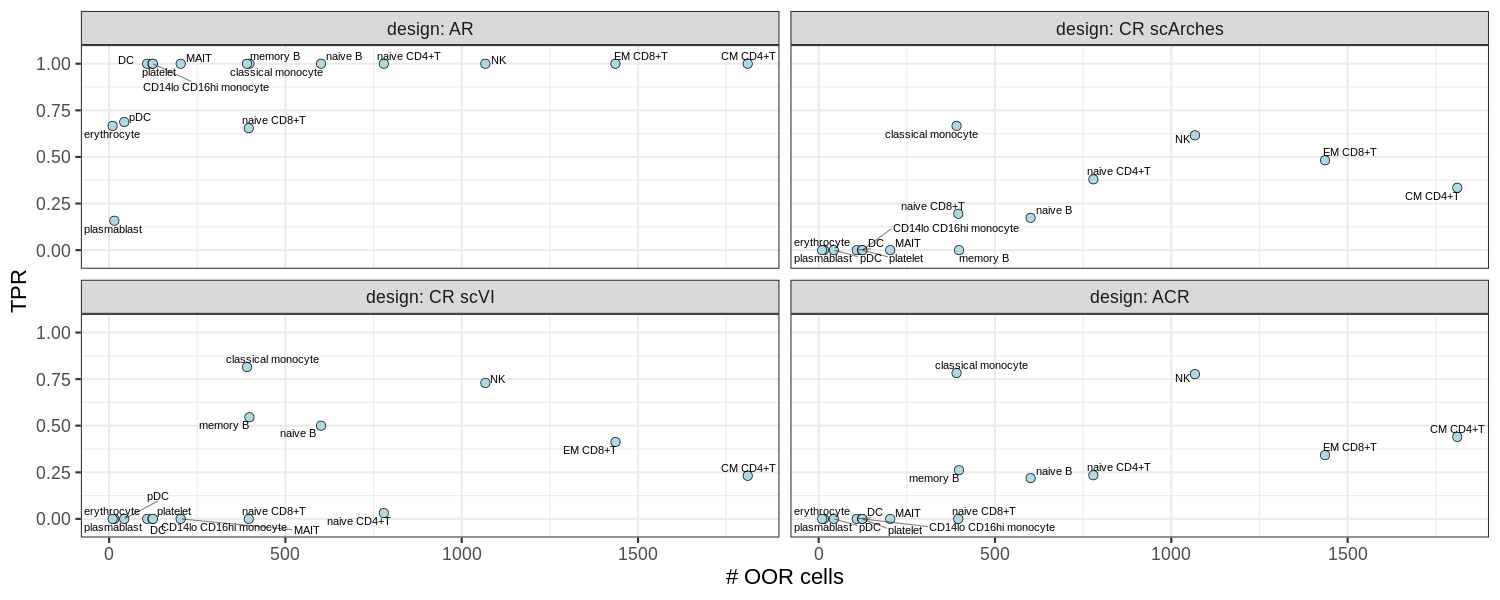

In [67]:
%%R -w 1500 -h 600 -i figdir
tpr_res_df_all %>%
#     filter(design=='ACR') %>%
    mutate(design = factor(design, c('AR', "CR scArches", "CR scVI", 'ACR'))) %>%
    ggplot(aes(OOR_state_ncells, TPR)) +
    geom_point(size=4, shape=21, fill='lightblue') +
    ggrepel::geom_text_repel(aes(label=perturb_pop_pl), max.overlaps = Inf, force=2, segment.alpha=0.5) +
    facet_wrap(design~., labeller='label_both', ncol=2) +
    xlab('# OOR cells') +
    theme_bw(base_size=22) +
    scale_y_continuous(expand = expansion(mult = 0.1)) +
    ggsave(paste0(figdir, "OOR_ncells_vs_TPR.pdf"), width=13, height=8) +
    ggsave(paste0(figdir, "OOR_ncells_vs_TPR.png"), width=13, height=8) +
    ggsave(paste0("/home/jovyan/mount/gdrive/diff2atlas/figure_panels/Supplementary_v2/Suppl_Figure_ncellsvsTPR.pdf"), width=13, height=8) +
    ggsave(paste0("/home/jovyan/mount/gdrive/diff2atlas/figure_panels/Supplementary_v2/Suppl_Figure_ncellsvsTPR.png"), width=13, height=8)

## Plot TPR/FPR/FDR

In [128]:
nhoods_res_df_all['OOR_state_ncells'] = [oor_state_size[x] if x in oor_state_size.keys() else np.nan for x in nhoods_res_df_all['OOR_state_name']]
tpr_res_df_all['OOR_state_ncells'] = [oor_state_size[x] if x in oor_state_size.keys() else np.nan for x in tpr_res_df_all['OOR_state_name']]

In [97]:
no_sensitivity = tpr_res_df_all[~tpr_res_df_all.design.str.startswith("AR")].groupby(["OOR_state_name"]).max()['TPR']
no_sensitivity = no_sensitivity.index[no_sensitivity == 0]
tpr_res_df_all = tpr_res_df_all[~tpr_res_df_all['OOR_state_name'].isin(no_sensitivity)]

In [98]:
no_sensitivity

Index(['CD14_low_CD16_positive_monocyte', 'conventional_dendritic_cell',
       'erythrocyte', 'mucosal_invariant_T_cell', 'plasmablast',
       'plasmacytoid_dendritic_cell', 'platelet'],
      dtype='object', name='OOR_state_name')

In [99]:
%%R -i tpr_res_df_all -w 1000 -h 400 

pl1 <- tpr_res_df_all %>%
    mutate(design=factor(design, levels=c('AR', 'CR scArches', 'CR scVI','ACR'))) %>%
    pivot_longer(cols=c("TPR", "FPR", "FDR"), names_to='metric') %>%
    ggplot(aes(design, value, color=design)) +
    geom_boxplot() +
    geom_jitter(size=3, width=0.05) +
    geom_line(aes(group=OOR_state_name), color='grey', alpha=0.6) +
    facet_wrap(metric~.) +
    scale_color_manual(values=design_palette) +
    theme_bw(base_size=24) +
    ylab("") +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5))


## Plot AUPRC

In [16]:
auprc_res_df_all = pd.DataFrame()
for d in [d for d in os.listdir(outdir) if d.endswith('_seed2022') and d.startswith('qPBMC_500cells_demo_perturb')]:
    diff_method = 'milo'
    if 'neutrophil' not in d:
        for embedding_method in ['scVI', 'scArches']:
            print(f'Reading {d}')
            print(f'Reading {d}')
            auprc_res_df = pd.read_csv(outdir + d + f'/AUPRC_res.{embedding_method}_{diff_method}.csv', index_col = 0)
            auprc_res_df['emb_method'] = embedding_method
            auprc_res_df_all = pd.concat([auprc_res_df_all, auprc_res_df])


Reading qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeerythrocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeerythrocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeerythrocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_perturb_cell_typeerythrocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_50

In [17]:
auprc_res_df_all.to_csv('../../../metadata/outputs/OOR_simulations_remove.AUPRC_results_all.csv')

In [103]:
no_sensitivity

Index(['CD14_low_CD16_positive_monocyte', 'conventional_dendritic_cell',
       'erythrocyte', 'mucosal_invariant_T_cell', 'plasmablast',
       'plasmacytoid_dendritic_cell', 'platelet'],
      dtype='object', name='OOR_state_name')

In [119]:
auprc_res_df = auprc_res_df_all[['OOR_state_name', 'design', 'AUPRC', 'no_skill_thresh', 'emb_method']].drop_duplicates()
# auprc_res_df = auprc_res_df[~auprc_res_df['OOR_state_name'].isin(no_sensitivity)]

In [120]:
## Keep 4 designs
auprc_res_df['design'] = np.where(auprc_res_df['design']=='CR', auprc_res_df['design'] + ' ' + auprc_res_df['emb_method'], auprc_res_df['design'])
auprc_res_df = auprc_res_df[auprc_res_df['design'].isin(["ACR", 'AR', 'CR scVI', 'CR scArches'])].copy()
auprc_res_df = auprc_res_df[~((auprc_res_df['design'] == 'ACR') & (auprc_res_df['emb_method'] == 'scVI'))]

In [121]:
auprc_res_df['OOR_state_ncells'] = [oor_state_size[x] if x in oor_state_size.keys() else np.nan for x in auprc_res_df['OOR_state_name']]

In [122]:
%%R -i auprc_res_df
head(auprc_res_df)

               OOR_state_name      design     AUPRC no_skill_thresh emb_method
1               memory_B_cell     CR scVI 0.8227029    0.0322580645       scVI
2               memory_B_cell         ACR 0.7737205    0.0691489362   scArches
3               memory_B_cell CR scArches 0.1681823    0.1017786561   scArches
4               memory_B_cell          AR 0.5673362    0.0008044371   scArches
5 conventional_dendritic_cell     CR scVI 0.4698171    0.0131180626       scVI
6 conventional_dendritic_cell         ACR 0.2889891    0.0081632653   scArches
  OOR_state_ncells
1              398
2              398
3              398
4              398
5              108
6              108


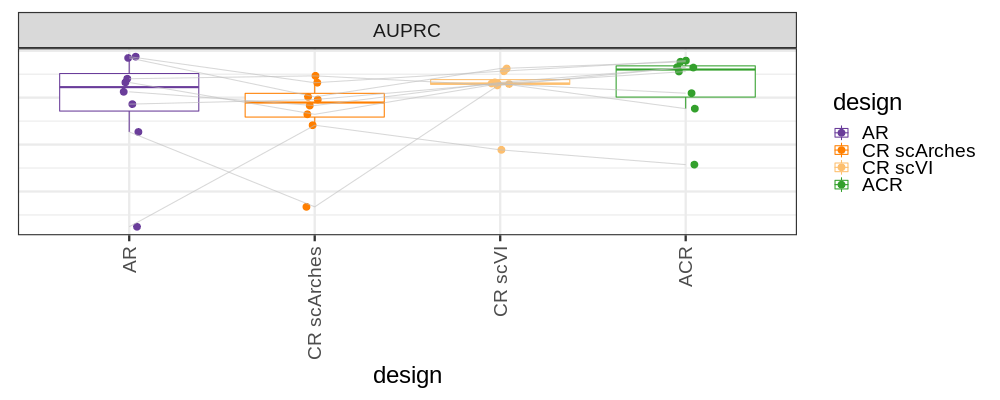

In [110]:
%%R -w 1000 -h 400 -i design_palette_df

pl2 <- auprc_res_df %>%
    mutate(design = factor(design, levels=c('AR', "CR scArches", "CR scVI", 'ACR'))) %>%
    pivot_longer(cols=c("AUPRC"), names_to='metric') %>%
    ggplot(aes(design, value, color=design)) +
    geom_boxplot(outlier.alpha=0) +
    geom_jitter(size=3, width=0.05) +
    geom_line(aes(group=OOR_state_name), color='grey', alpha=0.6) +
    facet_wrap(metric~.) +
    scale_color_manual(values=design_palette) +
    theme_bw(base_size=24) +
    remove_y_axis() +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)) 
    
pl2 

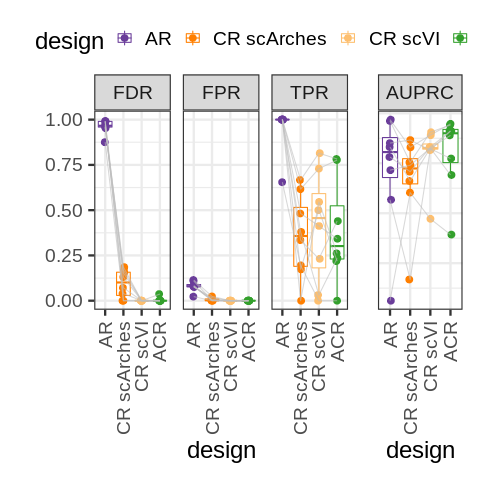

In [111]:
%%R
fig <- (pl1 + pl2) + plot_layout(widths=c(3,1), guides='collect') & 
    {theme(legend.position='top', legend.justification='right')} 

fig +
    ggsave(paste0(figdir, 'metrics_boxplot_design.png'), width=15, height=6) +
    ggsave(paste0(figdir, 'metrics_boxplot_design.pdf'), width=15, height=6)

## Assess integration quality (batch correction / bio-conservation)

Compute NMI between clusters and celltype/batch for each simulation + reference design.

On cluster:
```bash
conda activate oor-benchmark
cd /nfs/team205/ed6/bin/diff2atlas/src/2_simulation_design

outdir=/lustre/scratch126/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/
dirs=$(dirname $outdir/*/acr_design.h5ad)

for d in $dirs; do
    echo "python run_integration_quality.py ${d}/" | \
        bsub -G teichlab -o logfile-intqc-%J.out -e logfile-intqc-%J.err -M50000 -R "select[mem>50000] rusage[mem=50000]" 
done

## Just on disease
for d in $dirs; do
    echo "python run_integration_quality.py ${d}/ --filter_dataset query" | \
        bsub -G teichlab -o logfile-intqc-disease-%J.out -e logfile-intqc-disease-%J.err -M50000 -R "select[mem>50000] rusage[mem=50000]" 
done


```

In [76]:
intQC_all_df = pd.DataFrame()
for d in os.listdir(outdir):
    if not d.endswith('.h5ad') and d.startswith('qPBMC'):
        print(f'Reading {d}')
        try:
            intQC_df = pd.read_csv(outdir + d + '/integration_quality_filterquery.csv', index_col = 0)
            intQC_all_df = pd.concat([intQC_all_df, intQC_df])
        except:
            print('skipping')

Reading qPBMC_500cells_demo_shift_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
skipping
Reading qPBMC_500cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
Reading qPBMC_500cells_demo_shift_cell_typeeffector_memory_CD8_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
skipping
Reading qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022weighted_KNN_classifier.ctrl.pkl
skipping
Reading qPBMC_1000cells_demo_perturb_cell_typememory_B_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
skipping
Reading qPBMC_1000cells_demo_perturb_cell_typehematopoietic_precursor_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
skipping
Reading qPBMC_1000cells_demo_perturb_cell_typeplatelet_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022
skipping
Reading qPBMC_500cells_demo_mixed_cell_typeclassi

In [78]:
%%R -i intQC_all_df
head(intQC_all_df)

       design resolution NMI_celltype NMI_batch OOR_state_name
1 CR scArches       0.50    0.7336963 0.1169436  memory_B_cell
2 CR scArches       0.75    0.7028606 0.1313910  memory_B_cell
3 CR scArches       1.00    0.7056059 0.1304805  memory_B_cell
4 CR scArches       1.25    0.6900864 0.1324981  memory_B_cell
5 CR scArches       1.50    0.6831376 0.1315320  memory_B_cell
6 CR scArches       1.75    0.6527978 0.1332969  memory_B_cell


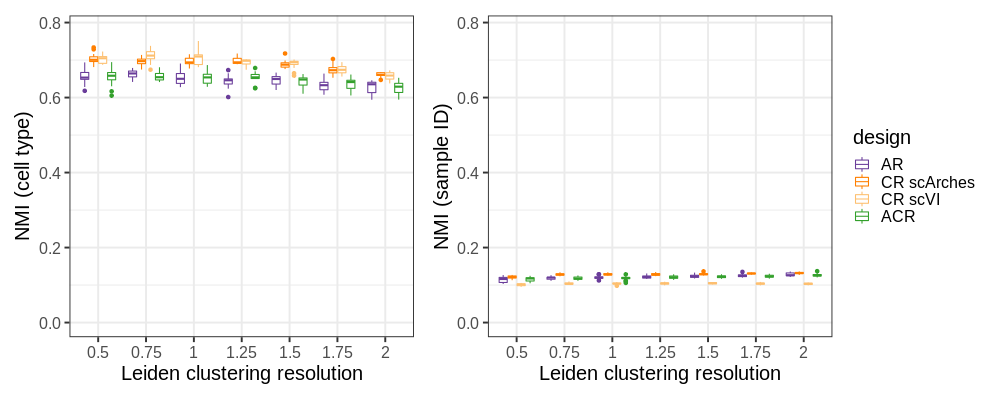

In [90]:
%%R -w 1000 -h 400
batch_pl <- intQC_all_df %>%
    mutate(design = factor(design, levels=c('AR', "CR scArches", 'CR scVI', 'ACR'))) %>%
    ggplot(aes(as.factor(resolution), NMI_batch, color=design)) +
    geom_boxplot() +
    # geom_line(aes(group=paste(OOR_state_name, design))) +
    ylim(0,0.78) +
    ylab('NMI (sample ID)') + 
    xlab("Leiden clustering resolution") +
    theme_bw(base_size=20) +
    scale_color_manual(values=design_palette) 
ct_pl <- intQC_all_df %>%
    mutate(design = factor(design, levels=c('AR', "CR scArches", 'CR scVI', 'ACR'))) %>%
    ggplot(aes(as.factor(resolution), NMI_celltype, color=design)) +
    geom_boxplot() +
    # geom_line(aes(group=paste(OOR_state_name, design))) +
    ylim(0,0.78) +
    ylab('NMI (cell type)') +
    xlab("Leiden clustering resolution") +
    theme_bw(base_size=20) +
    scale_color_manual(values=design_palette) 
    
ct_pl + batch_pl +
    plot_layout(guides='collect') +
    ggsave(paste0(figdir, "NMI_integration_plot.pdf"), width=10, height=4) +
    ggsave(paste0(figdir, "NMI_integration_plot.png"), width=10, height=4) +
    ggsave(paste0("~/mount/gdrive/diff2atlas/figure_panels/Supplementary_v2/Suppl_Figure_integrationQC.pdf"), width=12, height=4) +
    ggsave(paste0("~/mount/gdrive/diff2atlas/figure_panels/Supplementary_v2/Suppl_Figure_integrationQC.png"), width=12, height=4) 

In [71]:
import sklearn
sklearn.__version__

'1.1.2'